In [1]:
import pandas as pd
import re,string
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import warnings
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


# Value Similarity

In [3]:
df_ibm = pd.read_csv("ibm.csv")

In [4]:
core_values_ibm = """
passionate about building strong, long-lasting client relationships. This dedication spurs us to go "above and beyond" on our client's behalf.

focused on outcomes. We sell products, services and solutions to help our clients succeed, however they measure success.

demonstrate this personal dedication to every client, from the largest corporation and government agency to the smallest organization.

no matter where they work, have a role in client success. It requires the full spectrum of IBM expertise.

to lead in the creation, development and manufacture of the industry's most advanced information technologies, including computer systems, software, networking systems, storage devices and microelectronics.

are forward thinkers. We believe that the application of intelligence, reason and science can improve business, society and the human condition.

love grand challenges, as well as everyday improvements. Whatever the problem or the context, every IBMer seeks ways to tackle it creatively — to be an innovator.

strive to be first — in technology, in business, in responsible policy

actively build relationships with all the constituencies of our business — including clients, partners, communities, investors and fellow IBMers.

build trust by listening, following through and keeping their word.
"""

In [5]:
# Cosine Similarity
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer

stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')

def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

def cosine_pros_cons(df,value_list):
    df.columns = ['title', 'date_written', 'rating', 'current_former', 'job_title',
       'location', 'recommendation', 'outlook', 'main_text', 'pros', 'cons',
       'advice_to_management']

    df.pros = df.pros.astype(str)
    df.cons = df.cons.astype(str)
    
    pros = df.pros.sum()
    cons = df.cons.sum()

    for value in value_list:
        print(value)
        print("Similarity with pros:",cosine_sim(pros,value))
        print("Similarity with cons:",cosine_sim(cons,value))

In [6]:
cosine_pros_cons(df_ibm,core_values_ibm.split('\n\n'))


passionate about building strong, long-lasting client relationships. This dedication spurs us to go "above and beyond" on our client's behalf.
('Similarity with pros:', 0.03144398783419432)
('Similarity with cons:', 0.039976613917652476)
focused on outcomes. We sell products, services and solutions to help our clients succeed, however they measure success.
('Similarity with pros:', 0.03560276124310735)
('Similarity with cons:', 0.04592603653419965)
demonstrate this personal dedication to every client, from the largest corporation and government agency to the smallest organization.
('Similarity with pros:', 0.03078643677384109)
('Similarity with cons:', 0.06623133825532596)
no matter where they work, have a role in client success. It requires the full spectrum of IBM expertise.
('Similarity with pros:', 0.23464355435483794)
('Similarity with cons:', 0.1686043111343401)
to lead in the creation, development and manufacture of the industry's most advanced information technologies, includi

# Sentiment

In [6]:
fig_size = plt.rcParams["figure.figsize"]

#Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

In [12]:
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime
import copy
analyser = SentimentIntensityAnalyzer()

def get_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    return(snt['compound'])

def get_pos_neg(sentence):
    snt = analyser.polarity_scores(sentence)
    if(snt['pos'] > snt['neg']):
        return('pos')
    return('neg')

def sentiment_analysis(dfx):
    df = copy.deepcopy(dfx)
    df.columns = ['title', 'date_written', 'rating', 'current_former', 'job_title',
       'location', 'recommendation', 'outlook', 'main_text', 'pros', 'cons',
       'advice_to_management']

    df.pros = df.pros.astype(str)
    df.cons = df.cons.astype(str)
    
    df['pc'] = df.pros + ' ' + df.cons
    
    df['sent_score'] = df.pc.map(get_sentiment_scores)
    df['pos_neg'] = df.pc.map(get_pos_neg)
    
    df['date'] = pd.to_datetime(df['date_written'],errors = 'coerce')
    df.set_index('date', inplace=True)
    df2 = df[['sent_score']].resample("M").mean()
    y_mean = np.repeat(df['sent_score'].mean() ,df2.shape[0])
    plot(df2.index,y_mean,label='Mean', linestyle='--',color = 'k')
    plot(df2.index,df2['sent_score'])
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):

        print("Average sentiment score:",df['sent_score'].mean())

        print(df.groupby('current_former')[['sent_score']].mean())
        print(df.groupby('outlook')[['sent_score']].mean())
        print(df.groupby('recommendation')[['sent_score']].mean())

        print(df.job_title.value_counts()[:20])
        top_designations = df.job_title.value_counts().index[:20]
        print(df[df.job_title.isin(top_designations)].groupby('job_title')['sent_score'].mean().nlargest(20))

        print(df.location.value_counts()[:10])
        top_locations = df.location.value_counts().index[:10]
        print(df[df.location.isin(top_locations)].groupby('location')['sent_score'].mean().nlargest(10))
        print(df[df.location.isin(top_locations) & df.job_title.isin(top_designations)].pivot_table(index='location', columns='job_title', values='sent_score',aggfunc='mean'))
        #print(df[df.location.isin(top_locations) & df.job_title.isin(top_designations) ].groupby(['location','job_title'])[['sent_score']].mean())

/Users/tiffanysung/anaconda2/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


('Average sentiment score:', 0.47186826999999965)
                  sent_score
current_former              
Current Employee    0.479886
Former Employee     0.462150
                  sent_score
outlook                     
Negative Outlook    0.365816
Neutral Outlook     0.497008
Positive Outlook    0.567006
                   sent_score
recommendation               
Doesn't Recommend    0.373636
Recommends           0.567475
Anonymous Employee            5054
Software Engineer              231
Senior Consultant              134
Project Manager                131
Consultant                     104
Managing Consultant             97
Senior Software Engineer        89
IT Specialist                   72
Advisory Software Engineer      68
Staff Software Engineer         66
Program Manager                 61
Senior Managing Consultant      59
Senior Project Manager          57
Manager                         54
Financial Analyst               54
Sales                           46
Software 

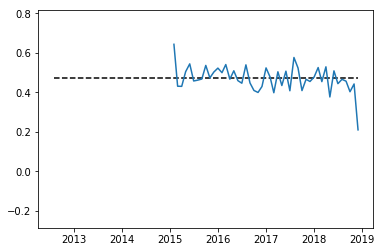

In [13]:
sentiment_analysis(df_ibm)